In [84]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [85]:
metric_dict = {
    "cola": "eval_matthews_correlation",
    "sst2": "eval_accuracy",
    "stsb": "eval_pearson",
    "qqp": "eval_accuracy",
    "mrpc": "eval_accuracy",
    "mnli": "eval_accuracy",
    "qnli": "eval_accuracy",
    "rte": "eval_accuracy",
}

In [86]:
experiment_dir = "experiments/few_shot"
tasks = os.listdir(experiment_dir)

diff_dict = {}

for task in tasks:
    runs = os.listdir(os.path.join(experiment_dir, task))
    runs_2 = [run for run in runs if "depth=2" in run]
    runs_3 = [run for run in runs if "depth=3" in run]
    runs_2_results = np.zeros(len(runs_2))
    runs_3_results = np.zeros(len(runs_3))
    for run in runs:
        seed = int(run.split("_")[-1].split("=")[1])
        with open(os.path.join(experiment_dir, task, run, "results.json")) as f:
            results = json.load(f)
        value = results[metric_dict[task]][0]['value']
        if "depth=2" in run:
            runs_2_results[seed] = value
        elif "depth=3" in run:
            runs_3_results[seed] = value
    diff_dict[task] = runs_3_results - runs_2_results

In [87]:
labels, series = list(zip(*diff_dict.items()))
series = np.array(series)

In [88]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels, fontsize=12)
    ax.set_xlim(0.25, len(labels) + 0.75)

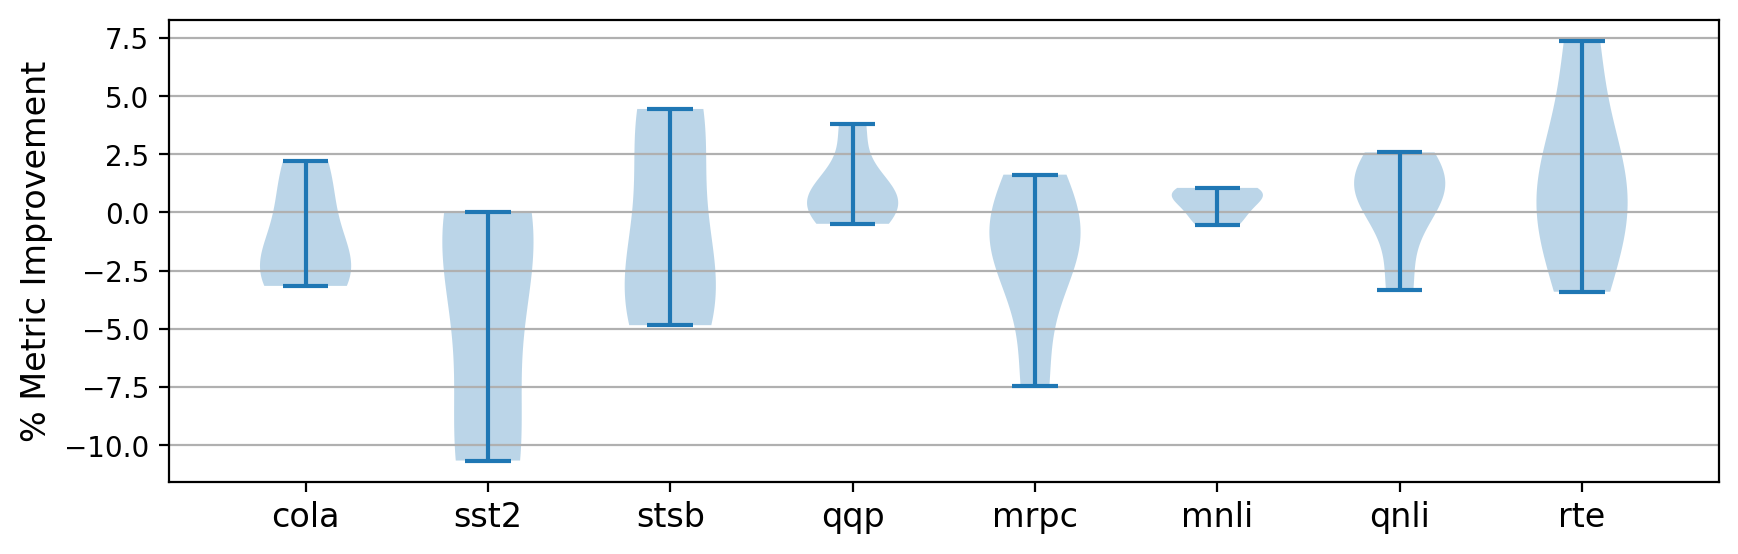

In [89]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.violinplot(series.T * 100)
ax.yaxis.grid(True)
ax.set_ylabel("% Metric Improvement", fontsize=12)

set_axis_style(ax, labels)